In [48]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from scipy.ndimage import label, generate_binary_structure
from project.utils import reindex_cell_labels
from project.cell import Cell, CellContainer

#### We load the curated testing set 

The annotation from CellPos program were manually checked to remove or correct error and establish a ground truth on a testing set that was not used to train DELTA models

In [3]:
true_seg_test_file = "data/ground_truth/segmentation/testing_set_curated.tif"
_, true_seg_test = cv2.imreadmulti(true_seg_test_file, [], cv2.IMREAD_ANYDEPTH)

#### Recovering DELTA predictions made with default weights

In [67]:
test_pred_dir = "data/predictions/segmentation/bad_weights_seg_out/"
list_files = sorted(os.listdir(test_pred_dir))
delta_d_test = np.zeros((125,512,512))

for f, file in enumerate(list_files):
    I = np.array(cv2.imread(test_pred_dir + file))
    I = I[:,:,0] # convert to gray scale 
    I[I>0] = 1 # Convert to binary mask
    delta_d_test[f,:,:] = label(I)[0]

In [404]:
"""
train_pred_dir = "delta_dev_branch/delta/training_curated_seg_1/seg_out/"
list_files = sorted(os.listdir(train_pred_dir))
delta_d_train = np.zeros((125,512,512))

for f, file in enumerate(list_files):
    I = np.array(cv2.imread(train_pred_dir + file))
    I_gray = (I[:,:,0] + I[:,:,1] + I[:,:,2] )/ 3
    I_gray[I_gray>0] = 1
    delta_d_train[f,:,:] = label(I_gray)[0]
"""

#### Recover DELTA predictions made with custom weights 

In [68]:
# Predictions are written in the form of many png files that needs to be compiled in a tif
test_pred_dir = "data/predictions/segmentation/delta_custom_weights_test/"
list_files = sorted(os.listdir(test_pred_dir))
delta_custom_test = np.zeros((125,512,512))
for f, file in enumerate(list_files):
    I = np.array(cv2.imread(test_pred_dir + file))
    I_gray = I[:,:,0]
    I_gray[I_gray>0] = 1
    delta_custom_test[f,:,:] = label(I_gray)[0]

#### Recovering Illastik predictions 

In [58]:
illastik_seg_file = "data/predictions/segmentation/ilastik/seg_ilastik_test.tif"
_, illastik_seg = cv2.imreadmulti(illastik_seg_file, [], cv2.IMREAD_ANYDEPTH)
illastik_segs_test = np.zeros((125,512,512))
for f in range(125):
    illastik_segs_test[f,:,:] = label(illastik_seg[f])[0]

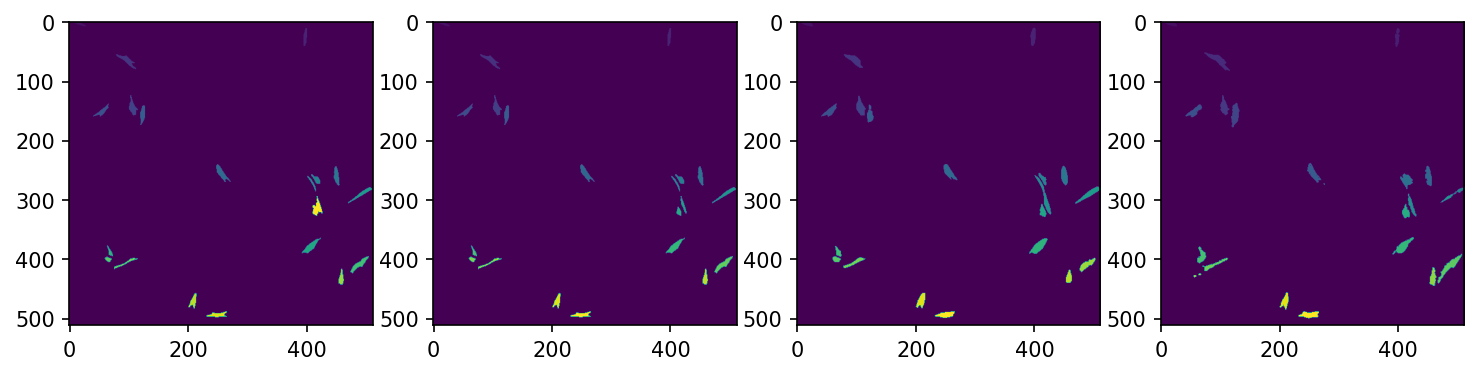

In [61]:
fig, axs = plt.subplots(1,4,figsize=(12,6), dpi=150)
axs[0].imshow(true_seg_test[0])
axs[1].imshow(delta_d_test[0])
axs[2].imshow(delta_custom_test[0])
axs[3].imshow(illastik_segs_test[0])

#### Score Cell Segmentation predictions

In the following line, we compare the overlap of each segmentation methods with the ground truth segmentation. As in DELTA original paper, we consider a segmentation as a success if there is enough overlap between the prediction and the ground truth, and a failure otherwise. In original DELTA, a threhold of 75% overlap was required. We lowered in at 51% as overlap seems to be generally lower in our biological context. The 51% threshold ensure that 2 cells cannot be counted as true. The overlap must satisfy A in B __and__ B in A. 

In [63]:
# Initialize list of results
scores_delta_te, accuracy_delta_te, scores_illastik_te, accuracy_illastik_te = [], [], [], []
scores_cu_te, accuracy_cu_te = [], []

# Iterate iver frames in movie to recover segmentation predictions
for f in range(125):
    print(f)
    
    ### Load data for testing set 
    true_segs_test = true_seg_test[f].copy()
    pseg_delta_d_te = delta_d_test[f].copy()
    pseg_illastik_te = illastik_segs_test[f].copy()
    pseg_delta_c_te = delta_custom_test[f].copy()
    cc_true_seg_te = CellContainer(true_segs_test)
    cc_pred_seg_i_te = CellContainer(pseg_illastik_te)
    cc_pred_seg_dd_te = CellContainer(pseg_delta_d_te)
    cc_pred_seg_dc_te = CellContainer(pseg_delta_c_te)
    
    # Test for DELTA default predictions / TESTING
    cc_true_seg_te.find_NN_other_frame(cc_pred_seg_dd_te, 'tp1')
    score_d, acc_d = cc_true_seg_te.score_surface(true_segs_test, pseg_delta_d_te)
    scores_delta_te.append(score_d)
    accuracy_delta_te.append(acc_d)
    
    # Test for DELTA with custom weights / TESTING 
    cc_true_seg_te = CellContainer(true_segs_test)
    cc_true_seg_te.find_NN_other_frame(cc_pred_seg_dc_te, 'tp1')
    score_cu, acc_cu = cc_true_seg_te.score_surface(true_segs_test, pseg_delta_c_te)
    scores_cu_te.append(score_cu)
    accuracy_cu_te.append(acc_cu)
    
    # Test for ILLASTIK predictions / TESTING
    cc_true_seg_te = CellContainer(true_segs_test)
    cc_true_seg_te.find_NN_other_frame(cc_pred_seg_i_te, 'tp1')
    score_i, acc_i = cc_true_seg_te.score_surface(true_segs_test, pseg_illastik_te)
    scores_illastik_te.append(score_i)
    accuracy_illastik_te.append(acc_i)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124


In [64]:
range_acc_illastik, range_acc_delta, range_acc_delta_c = [], [], []
for i in range(12):
    range_acc_illastik.append(np.array(accuracy_illastik_te)[i*10:i*10+10])
    range_acc_delta.append(np.array(accuracy_delta_te)[i*10:i*10+10])
    range_acc_delta_c.append(np.array(accuracy_cu_te)[i*10:i*10+10])

In [65]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

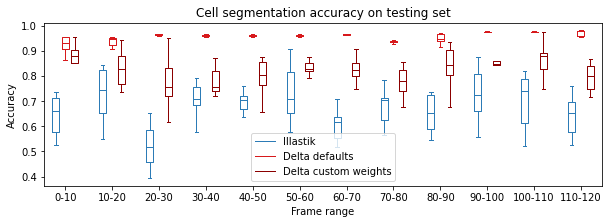

In [66]:
plt.figure(figsize=(10,3))
btr = plt.boxplot(range_acc_illastik, positions=np.array(range(len(range_acc_illastik)))*2.0-0.4, sym='', widths=0.3)
bte = plt.boxplot(range_acc_delta, positions=np.array(range(len(range_acc_delta)))*2.0, sym='', widths=0.3)
btc = plt.boxplot(range_acc_delta_c, positions=np.array(range(len(range_acc_delta)))*2.0+0.4, sym='', widths=0.3)
set_box_color(btr, '#2C7BB6') # colors are from http://colorbrewer2.org/
set_box_color(bte, '#D7191C')
set_box_color(btc, 'darkred')

plt.xticks([0,2,4,6,8,10,12,14,16,18,20,22],
           ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100','100-110','110-120'])
plt.xlabel('Frame range')
plt.ylabel('Accuracy')
plt.title('Cell segmentation accuracy on testing set')
plt.legend([btr["boxes"][0], bte["boxes"][0], btc["boxes"][0]], ['Illastik', 'Delta defaults', 'Delta custom weights'], 
           loc='lower center')
#plt.savefig('results_explore_tif/cell_segmentation_testing_range10.pdf',dpi=300, bbox_inches='tight')
plt.show()

In [473]:
range_acc_illastik, range_acc_delta, range_acc_delta_c = [], [], []
range_width=25
for i in range(5):
    range_acc_illastik.append(np.array(accuracy_illastik_tr)[i*range_width:i*range_width+range_width])
    range_acc_delta.append(np.array(accuracy_delta_te)[i*range_width:i*range_width+range_width])
    range_acc_delta_c.append(np.array(accuracy_cu_te)[i*range_width:i*range_width+range_width])

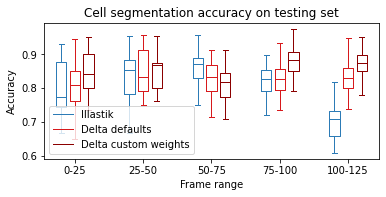

In [475]:
plt.figure(figsize=(6,2.5))
btr = plt.boxplot(range_acc_illastik, positions=np.array(range(len(range_acc_illastik)))*2.0-0.4, sym='', widths=0.3)
bte = plt.boxplot(range_acc_delta, positions=np.array(range(len(range_acc_delta)))*2.0, sym='', widths=0.3)
btc = plt.boxplot(range_acc_delta_c, positions=np.array(range(len(range_acc_delta)))*2.0+0.4, sym='', widths=0.3)
set_box_color(btr, '#2C7BB6') # colors are from http://colorbrewer2.org/
set_box_color(bte, '#D7191C')
set_box_color(btc, 'darkred')

plt.xticks([0,2,4,6,8],
           ['0-25','25-50','50-75','75-100','100-125'])
plt.xlabel('Frame range')
plt.ylabel('Accuracy')
plt.title('Cell segmentation accuracy on testing set')
plt.legend([btr["boxes"][0], bte["boxes"][0], btc["boxes"][0]], ['Illastik', 'Delta defaults', 'Delta custom weights'], 
           loc='lower left')
plt.savefig('results_explore_tif/cell_segmentation_testing_range25.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [471]:
stack_acc_tr = np.array([np.array(accuracy_illastik_te), np.array(accuracy_delta_tr), np.array(accuracy_cu_tr)])
stack_acc_te = np.array([np.array(accuracy_illastik_tr), np.array(accuracy_delta_te), np.array(accuracy_cu_te)])

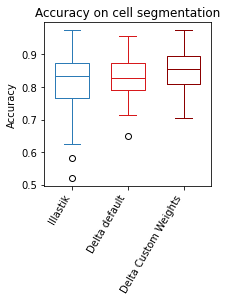

In [389]:
plt.figure(figsize=(3,3))
btr_tr = plt.boxplot(stack_acc_tr.T[:,0], positions=[0]-0.4, widths=0.6)
btr_te = plt.boxplot(stack_acc_te.T[:,0], positions=[0]+0.4, widths=0.6)

bte_tr = plt.boxplot(stack_acc_tr.T[:,1], positions=[1]-0.4, widths=0.6)
bte_te = plt.boxplot(stack_acc_te.T[:,1], positions=[1]+0.4, widths=0.6)

btc_tr = plt.boxplot(stack_acc_tr.T[:,2], positions=[2]-0.4, widths=0.6)
btc_te = plt.boxplot(stack_acc_te.T[:,2], positions=[2]+0.4, widths=0.6)


set_box_color(btr, '#2C7BB6') # colors are from http://colorbrewer2.org/
set_box_color(bte, '#D7191C')
set_box_color(btc, 'darkred')

plt.xticks([0,1,2], ['Illastik', 'Delta default', 'Delta Custom Weights'], rotation=60, ha='right')
plt.ylabel('Accuracy')
plt.title('Accuracy on cell segmentation')
#plt.savefig('results_explore_tif/cell_segmentation_testing_overall.pdf',dpi=300)
plt.show()

In [375]:
np.median(stack_acc.T[:,2])

0.8541666666666666

### Other stuff

In [7]:
imageio.mimwrite('data/testing_SEGpred_default_weights_1.tif', tif_obj)

In [17]:
# Predictions are written in the form of many png files that needs to be compiled in a tif
seg_cellpos_file = "data/_fullmovie_segmentation_cellpose_v2.tif"
_, seg_cellpos = cv2.imreadmulti(seg_cellpos_file, [], cv2.IMREAD_ANYDEPTH)

In [25]:
cellpos_training = np.zeros((125, 512, 512))
for f in range(125):
    cellpos_training[f,:,:] = reindex_cell_labels(seg_cellpos[f][1024:1536,0:512])

In [34]:
imageio.mimwrite('data/testing_cellpos_seg.tif', cellpos_training)

#### Recoving predicted cell segmentation without labels 

In [ ]:
# This is a work around to work with the image subsets we have :
label_file = "/Users/acoudray/Desktop/tmp_samba/phd_courses/machine_learning/project2/data/testing_SEGpred_default_weights_1.tif"
_, labels = cv2.imreadmulti(label_file, [], cv2.IMREAD_ANYDEPTH)

In [ ]:
uniq_labs = np.zeros((125,512,512))
for i in range(len(labels)):
    labeled_array, num_features = label(labels[i].copy()) # This use label() function from scipy.ndimage
    uniq_labs[i, :, :] = labeled_array

In [ ]:
imageio.mimwrite('data/testing_SEGpred_default_weights_UNIQLAB_1.tif', uniq_labs)

### Recovring curated testing set cell segmentation 

In [35]:
# Predictions are written in the form of many png files that needs to be compiled in a tif
seg_curat_file = "data/testing_SEGpred_CURATED.tif"
_, seg_curat = cv2.imreadmulti(seg_curat_file, [], cv2.IMREAD_ANYDEPTH)

In [57]:
seg_curat_reform = np.zeros((125,512,512))
for f in range(len(seg_curat)):
    seg_curat_reform[f,:,:] = reindex_cell_labels(seg_curat[f]).astype('uint16')

In [61]:
imageio.mimwrite('data/testing_SEGpred_CURATED_REFORM.tif', seg_curat_reform)

#### Let's use labeling function from DELTA 

In [ ]:
def label_seg(seg,cellnumbers=None,return_contours=False,background=0):
    '''
    Label cells in segmentation mask

    Parameters
    ----------
    seg : numpy 2D array of float/uint8/uint16/bool
        Cells segmentation mask. Values >0.5 will be considered cell pixels
    cellnumbers : list of ints, optional
        Numbers to attribute to each cell mask, from top to bottom of image.
        Because we are using uint16s, maximum cell number is 65535. If None is 
        provided, the cells will be labeled 1,2,3,... Background is 0
        The default is None.

    Returns
    -------
    label : 2D numpy array of uint16
        Labelled image. Each cell in the image is marked by adjacent pixels 
        with values given by cellnumbers

    '''
    if seg.dtype == bool:
        seg = seg.astype(np.uint8)
    else:
        seg = cv2.threshold(seg,.5,1,cv2.THRESH_BINARY)[1].astype(np.uint8)
    contours = cv2.findContours(seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    contours_s = sorted(contours, key=lambda elem: np.max(elem[:,0,1])) # Sorting along Y
    label = np.full(seg.shape,background,dtype=np.uint16)
    for c, contour in enumerate(contours_s):
        label = cv2.fillPoly(label,[contour],c+1 if cellnumbers is None else cellnumbers[c])
    if return_contours:
        return label, contours
    else:
        return label

In [ ]:
this_lab = label_seg(labels[0])
plt.imshow(this_lab)

In [ ]:
uniq_labs = np.zeros((125,512,512))
for i in range(len(labels)):
    labeled_array = label_seg(labels[i].copy()) # This use label_seg() function from DELTA.utilities
    uniq_labs[i, :, :] = labeled_array

In [ ]:
imageio.mimwrite('data/testing_SEGpred_default_weights_UNIQLAB_2.tif', uniq_labs)

Take home message after viewing both cell segmentation results : scipy.ndimage.label and delta.utilities.seg_label are producing the same output with the same problem : cells that are close from each other are getting glued together.. ! 

### Script to separate cells that are close by 

In [ ]:
def euc_dist(arr1, arr2):
    return(np.linalg.norm(arr1 - arr2))

def reindex_cell_labels(img):
    idx = np.unique(img)
    for i, x in enumerate(idx):
        img[img == x] = i
    return(img)

class Cell:
    def __init__(self, label, x_m=None, y_m=None, size=None):
        self.label = label
        self.pxl_pos = None 
        self.x_m = x_m
        self.y_m = y_m
        self.size = size
        self.dist2board = None
        self.c_pos = None
        self.nn_t = [None, 1000]
        self.nn_tp1 = [None, 1000]
        self.self_tp1 = [None, 1000]
        self.nn_tp2 = [None, 1000]
        self.self_tp2 = [None, 1000]
        
    def dist_to_board(self, img):
        self.dist2board = min(min(abs(self.y_m - 0), abs(self.y_m - img.shape[1])),
                              min(abs(self.x_m - 0), abs(self.x_m - img.shape[0])) )
    
    def define_pos(self, pxl_pos_x, pxl_pos_y):
        self.x_m = int(np.mean(pxl_pos_x))
        self.y_m = int(np.mean(pxl_pos_y))
        self.c_pos = np.array([self.x_m, self.y_m])
        self.size = len(self.pxl_pos[:,0])
        
    def get_pos_from_img(self, img):
        self.pxl_pos = np.argwhere(img == self.label)
        self.x_m = int(np.mean(self.pxl_pos[:,0]))
        self.y_m = int(np.mean(self.pxl_pos[:,1]))
        self.c_pos = np.array([self.x_m, self.y_m])
        self.size = len(self.pxl_pos[:,0])
        
    def find_NN(self, cellc):
        n_cells = len(cellc.cells)
        for m, lab in enumerate(cellc.cells_labels):
            if lab != self.label:
                d = euc_dist(self.c_pos, cellc.cells[m].c_pos)
                if d < self.nn_t[1]:
                    self.nn_t[0] = lab
                    self.nn_t[1] = d
                    
    def find_NN_otherFrame(self, cellc, timepoint='tp1'):
        n_cells = len(cellc.cells)
        for m, lab in enumerate(cellc.cells_labels):
            d = euc_dist(self.c_pos, cellc.cells[m].c_pos)
            if timepoint == 'tp1':
                if d < self.self_tp1[1]:
                    self.self_tp1[0] = lab
                    self.self_tp1[1] = d
            elif timepoint == 'tp2':
                if d < self.self_tp2[1]:
                    self.self_tp2[0] = lab
                    self.self_tp2[1] = d
                    
        for m, lab in enumerate(cellc.cells_labels):
            d = euc_dist(self.c_pos, cellc.cells[m].c_pos)
            if timepoint == 'tp1':
                if lab != self.self_tp1[0]:
                    if d < self.nn_tp1[1]:
                        self.nn_tp1[0] = lab
                        self.nn_tp1[1] = d
            elif timepoint == 'tp2':
                if lab != self.self_tp2[0]:
                    if d < self.nn_tp2[1]:
                        self.nn_tp2[0] = lab
                        self.nn_tp2[1] = d
                
class CellContainer:
    def __init__(self):
        self.cells = []
        self.cells_x = []
        self.cells_y = [] 
        self.cells_labels = []  
        self.n_c = 0
        
    def init_from_img(self, img):
        cells_idx = np.unique(img)
        cells_idx = cells_idx[cells_idx!=0]
        for i, idx in enumerate(cells_idx):
            cell = Cell(idx) # create a cell with a label
            cell.get_pos_from_img(img) # get info about pixel, size and center of cell
            cell.dist_to_board(img) # calculate minimal distance to image boarders
            self.add_cell(cell)
    
    def create_cell_from_pos(self, pxl_pos_x, pxl_pos_y, cell_idx):
        cell = Cell(cell_idx)
        cell.define_pos(pxl_pos_x, pxl_pos_y)
        self.add_cell(cell)
    
    def add_cell(self, cell):
        self.cells.append(cell)
        self.cells_x.append(cell.x_m)
        self.cells_y.append(cell.y_m)
        self.cells_labels.append(cell.label)
    
    def replace_cell(self, pxl_pos_x, pxl_pos_y, cell_idx):
        cell = Cell(cell_idx)
        cell.define_pos(pxl_pos_x, pxl_pos_y)
        self.cells[cell_idx] = cell
        self.cells_x[cell_idx] = cell.x_m
        self.cells_y[cell_idx] = cell.y_m
        
    def find_NN(self):
        for i, idx in enumerate(self.cells_labels):
            self.cells[i].find_NN(self)
            
    def find_NN_other_frame(self, cc_next, timepoint = 'tp1'):
        for i, idx in enumerate(self.cells_labels):
            self.cells[i].find_NN_otherFrame(cc_next, timepoint)

In [ ]:
cell_container_t = CellContainer()
cell_container_t.init_from_img(uniq_labs[124,:,:])
cell_container_t.find_NN()

In [244]:
coi = 20 # cell of interest label
cell_container_t.cells[coi-1].size

195

Indeed this one is a big cell ! -> It actually comes from multiple cells glued together .. ! 

In [399]:
final_seg = np.zeros((125,512,512))

for f in range(125):
    I = cell_img[f].copy()
    I_seg = uniq_labs[f,:,:].copy()

    # Hereafter, a filtering that would apply a cell-specific filtering
    '''
    all_labels = np.unique(I_seg)
    all_labels = all_labels[all_labels!=0]

    final_label = np.zeros((512,512))
    for lab in all_labels:
        I_tmp = I.copy() ; I_seg_tmp = I_seg.copy()
        I_tmp[uniq_labs[f,:,:] != lab] = 0
        I_seg_tmp[uniq_labs[f,:,:] != lab] = 0

        flat_img = I_tmp.flatten()
        flat_seg = I_seg_tmp.flatten()
        flat_img_sub = flat_img[flat_img != 0].copy()
        flat_seg[flat_img < np.mean(flat_img_sub)] = 0

        final_label += flat_seg.reshape(512,-1)
    '''
    
    # Hereafter, an image-specific filtering 
    flat_img = I.flatten()
    flat_seg = I_seg.flatten()
    flat_img_sub = flat_img[flat_img != 0].copy()
    
    # We use only the top X percent signal (can be adapted depending on predictions)
    flat_seg[flat_img < np.quantile(flat_img_sub, q=0.95)] = 0
    final_label = flat_seg.reshape(512,-1)
    
    final_label[final_label > 0] = 1

    final_label_r, num_features = scipy.ndimage.label(final_label)

    cell_container_t = CellContainer()
    cell_container_t.init_from_img(final_label_r)

    cell_sizes = [] ; cell_labs = []
    for i, lab in enumerate(cell_container_t.cells_labels):
        cell_sizes.append(cell_container_t.cells[i].size)
        cell_labs.append(lab)

    cells_to_rm = np.array(cell_labs)[np.array(cell_sizes) < 20]

    for lab in cells_to_rm:   
        final_label_r[final_label_r == lab] = 0
    
    final_seg[f,:,:] = final_label_r

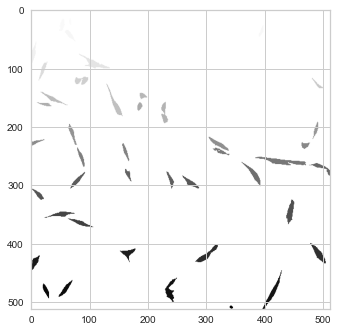

In [400]:
plt.imshow(final_seg[124,:,:])

In [401]:
imageio.mimwrite('data/testing_SEGpred_default_weights_UNIQLAB_FILTER_1.tif', final_seg)

In [28]:
import numpy as np
import numpy.linalg as lin

In [36]:
a = np.array([1, 0, 0])
Theta = np.array([[0.7,0.2,0.1],[0.2,0.7,0.1],[0.2,0.1,0.7]])

In [37]:
0.2 * lin.matrix_power(Theta,5) @ [1, 0, 1]

array([0.129862, 0.123612, 0.139164])

In [38]:
0.2 * lin.matrix_power(Theta,5) @ np.array([1, 0, 0]) + 0.8 * lin.matrix_power(Theta,5) @ np.array([0, 0, 1])

array([0.268198, 0.261948, 0.324156])

In [39]:
np.array([0.2, 0, 0.8]) @ lin.matrix_power(Theta,5).T

array([0.268198, 0.261948, 0.324156])

In [219]:
def euc_dist(arr1, arr2):
    return(np.linalg.norm(arr1 - arr2))

def reindex_cell_labels(img):
    idx = np.unique(img)
    for i, x in enumerate(idx):
        img[img == x] = i
    return(img)

class Cell:
    def __init__(self, label, x_m=None, y_m=None, size=None):
        self.label = label
        self.pxl_pos = None 
        self.x_m = x_m
        self.y_m = y_m
        self.size = size
        self.dist2board = None
        self.c_pos = None
        self.nn_t = [None, 1000]
        self.nn_tp1 = [None, 1000]
        self.self_tp1 = [None, 1000]
        self.nn_tp2 = [None, 1000]
        self.self_tp2 = [None, 1000]
        
    def dist_to_board(self, img):
        self.dist2board = min(min(abs(self.y_m - 0), abs(self.y_m - img.shape[1])),
                              min(abs(self.x_m - 0), abs(self.x_m - img.shape[0])) )
        
    def get_pos_from_img(self, img):
        self.pxl_pos = np.argwhere(img == self.label)
        self.x_m = int(np.mean(self.pxl_pos[:,0]))
        self.y_m = int(np.mean(self.pxl_pos[:,1]))
        self.c_pos = np.array([self.x_m, self.y_m])
        self.size = len(self.pxl_pos[:,0])
        
    def find_NN(self, cellc):
        n_cells = len(cellc.cells)
        for m, lab in enumerate(cellc.cells_labels):
            if lab != self.label:
                d = euc_dist(self.c_pos, cellc.cells[m].c_pos)
                if d < self.nn_t[1]:
                    self.nn_t[0] = lab
                    self.nn_t[1] = d
                    
    def find_NN_otherFrame(self, cellc, timepoint='tp1'):
        n_cells = len(cellc.cells)
        for m, lab in enumerate(cellc.cells_labels):
            d = euc_dist(self.c_pos, cellc.cells[m].c_pos)
            if timepoint == 'tp1':
                if d < self.self_tp1[1]:
                    self.self_tp1[0] = lab
                    self.self_tp1[1] = d
            elif timepoint == 'tp2':
                if d < self.self_tp2[1]:
                    self.self_tp2[0] = lab
                    self.self_tp2[1] = d
                    
        for m, lab in enumerate(cellc.cells_labels):
            d = euc_dist(self.c_pos, cellc.cells[m].c_pos)
            if timepoint == 'tp1':
                if lab != self.self_tp1[0]:
                    if d < self.nn_tp1[1]:
                        self.nn_tp1[0] = lab
                        self.nn_tp1[1] = d
            elif timepoint == 'tp2':
                if lab != self.self_tp2[0]:
                    if d < self.nn_tp2[1]:
                        self.nn_tp2[0] = lab
                        self.nn_tp2[1] = d
                
class CellContainer:
    def __init__(self, img):
        self.cells = []
        self.cells_x = []
        self.cells_y = [] 
        self.cells_labels = []  
        self.n_c = 0
        self.init_from_img(img)

    def init_from_img(self, img):
        cells_idx = np.unique(img)
        cells_idx = cells_idx[cells_idx!=0]
        for i, idx in enumerate(cells_idx):
            cell = Cell(idx) # create a cell with a label
            cell.get_pos_from_img(img) # get info about pixel, size and center of cell
            cell.dist_to_board(img) # calculate minimal distance to image boarders
            self.add_cell(cell)
    
    def add_cell(self, cell):
        self.cells.append(cell)
        self.cells_x.append(cell.x_m)
        self.cells_y.append(cell.y_m)
        self.cells_labels.append(cell.label)
        self.n_c+=1

    def find_NN(self):
        for i, idx in enumerate(self.cells_labels):
            self.cells[i].find_NN(self)
            
    def find_NN_other_frame(self, cc_next, timepoint = 'tp1'):
        for i, idx in enumerate(self.cells_labels):
            self.cells[i].find_NN_otherFrame(cc_next, timepoint)

    def score_surface(self, seg_true, seg_pred):
        mean_score=0
        nbr_zero_score=0
        hit, n_cells_considered = 0, 0
        for i, lab_train in enumerate(self.cells_labels):
            # ignore small cells 
            if self.cells[i].size < 20:
                next
            n_cells_considered+=1
            
            lab_test=self.cells[i].self_tp1[0] #label of the test image

            seg_pred_1c = seg_pred.copy()
            seg_pred_1c[seg_pred_1c!=lab_test]=0 #only the cell is different than 0
            seg_pred_1c[seg_pred_1c==lab_test]=1 #binary mask for the cell

            seg_true_1c=seg_true.copy()
            seg_true_1c[seg_true_1c!=lab_train]=0 
            seg_true_1c[seg_true_1c==lab_train]=1 #binary mask 

            sum_lab = seg_true_1c+seg_pred_1c 

            common_surface = sum_lab.copy()
            common_surface[sum_lab<=1] = 0
            nb_union = np.count_nonzero(sum_lab.copy())
            nb_common_surface = np.count_nonzero(common_surface)
            score = nb_common_surface/nb_union
            
            if nb_common_surface == 0: #if the commmon surface is null, then we don't consider this pair of cells.
                nbr_zero_score+=1
            mean_score+=score
            
            # Second metric of accuracy
            true_surface = np.count_nonzero(seg_true_1c)
            pred_surface = np.count_nonzero(seg_pred_1c)
            ratio_true = nb_common_surface / true_surface
            ratio_pred = nb_common_surface / pred_surface
            if ratio_true > 0.51 and ratio_pred > 0.51:
                hit+=1 

        mean_score=mean_score/(n_cells_considered+1-nbr_zero_score)
        ratio_hit = hit / (n_cells_considered+1-nbr_zero_score)
        return mean_score, ratio_hit